<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-engineering-of-Imerge-dataframe" data-toc-modified-id="Feature-engineering-of-Imerge-dataframe-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature engineering of Imerge dataframe</a></span></li><li><span><a href="#One-Hot-and-Label-Encoding-of-trIeng_df-dataframe" data-toc-modified-id="One-Hot-and-Label-Encoding-of-trIeng_df-dataframe-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>One Hot and Label Encoding of trIeng_df dataframe</a></span></li><li><span><a href="#testing-dummified-and-label-encoded-dfs-with-t-distributed-Stochastic-Neighbor-Embedding" data-toc-modified-id="testing-dummified-and-label-encoded-dfs-with-t-distributed-Stochastic-Neighbor-Embedding-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>testing dummified and label encoded dfs with t-distributed Stochastic Neighbor Embedding</a></span></li></ul></div>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style = "whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size*1.1,
          'axes.titlesize': size*2,
          'xtick.labelsize': size*1.1,
          'ytick.labelsize': size*1.1,
          'axes.titlepad': 25,
          'figure.titlesize': size*2,
          'legend.fontsize': size,
            'legend.title_fontsize': size*1.1
         }

plt.rcParams.update(params)

sns.set_style("whitegrid")

In [4]:
# read in dataframes from binaries
trB= pd.read_pickle("./data/trB.pkl") # Train Beneficiaries 
trO= pd.read_pickle("./data/trO.pkl") # Train Outpatient Claims
trI= pd.read_pickle("./data/trI.pkl") # Train Inpatient Claims
trF= pd.read_pickle("./data/trF.pkl") # Train Provider Fraud

In [129]:
# three way merge of Inpatient claims, drop uneeded columns and 'ClmProcedureCode_6' which is empty
Imerge = trF.merge(trI.merge(trB, on='BeneID'), on='Provider').drop(['index','index_x','index_y', 'DOB', 'ClaimID','ClmProcedureCode_6','DeductibleAmtPaid' ], axis=1)

In [382]:
# convert potentialfraud to binary

vals = {'Yes' : 1, 'No' : 0} 
Imerge['PotentialFraud'] = Imerge['PotentialFraud'].map(vals)


In [130]:
# feature engineering: Add features: calculate days between ClaimStartDt-ClaimEndDt, AdmissionDt-DischargeDt
# convert to datetime
Imerge['ClaimStartDt']= pd.to_datetime(Imerge['ClaimStartDt'])
Imerge['ClaimEndDt']= pd.to_datetime(Imerge['ClaimEndDt'])
Imerge['AdmissionDt']= pd.to_datetime(Imerge['AdmissionDt'])
Imerge['DischargeDt']= pd.to_datetime(Imerge['DischargeDt'])

# days of admission and claim duration
Imerge['ClaimDuration'] =(Imerge['ClaimEndDt']- Imerge['ClaimStartDt']).dt.days
Imerge['AdmitDays'] =(Imerge['DischargeDt']- Imerge['AdmissionDt']).dt.days

# change dates to day of year
Imerge['ClaimStartDt']= Imerge['ClaimStartDt'].apply(lambda x: x.timetuple().tm_yday)
Imerge['ClaimEndDt']= Imerge['ClaimEndDt'].apply(lambda x: x.timetuple().tm_yday)
Imerge['AdmissionDt']= Imerge['AdmissionDt'].apply(lambda x: x.timetuple().tm_yday)
Imerge['DischargeDt']= Imerge['DischargeDt'].apply(lambda x: x.timetuple().tm_yday)

In [131]:
# Change DOD to binary

Imerge['DOD'].loc[~Imerge['DOD'].isnull()] = 1 # returns warning but still works
Imerge['DOD'].fillna(0, inplace = True)


/Users/RK/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [186]:
# sum number of diagnostic or procedure codes and add into new columns

diag=['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10']
proc=['ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5']

Imerge['numDiagCodes'] = Imerge[diag].count(1)
Imerge['numProcCodes'] = Imerge[proc].count(1)

0        29650
1         0388
2        56211
3         4241
4        85222
         ...  
40469     None
40470     None
40471     None
40472     None
40473     None
Length: 404740, dtype: object

In [133]:
# sum number of physicians and add into new column
phys = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']
Imerge['numPhysicians'] = Imerge[phys].count(1)

In [134]:
# Fix 'RenalDiseaseIndicator' column: '0' to 2, 'Y' to 1
# trB['RenalDiseaseIndicator'] = np.where(trB['RenalDiseaseIndicator']=='0', 2, trB['RenalDiseaseIndicator'])
# trB['RenalDiseaseIndicator'] = np.where(trB['RenalDiseaseIndicator']=='Y', 1, trB['RenalDiseaseIndicator'])
# trB['RenalDiseaseIndicator']= trB['RenalDiseaseIndicator'].astype('int64')


# Change chronic conditions to binary

ccols=['RenalDiseaseIndicator','ChronicCond_Alzheimer','ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease','ChronicCond_Cancer','ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression','ChronicCond_Diabetes','ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis','ChronicCond_rheumatoidarthritis','ChronicCond_stroke']

Imerge[ccols] = np.where(Imerge[ccols]==2, 0, Imerge[ccols])

In [187]:
# Average Reimbursment per day per claim
Imerge['ReimbPerDayAdmit']= Imerge['InscClaimAmtReimbursed']/(Imerge['AdmitDays']+0.001)


In [384]:
Imerge.dtypes

Provider                            object
PotentialFraud                       int64
BeneID                              object
ClaimStartDt                         int64
ClaimEndDt                           int64
InscClaimAmtReimbursed               int64
AttendingPhysician                  object
OperatingPhysician                  object
OtherPhysician                      object
AdmissionDt                          int64
ClmAdmitDiagnosisCode               object
DischargeDt                          int64
DiagnosisGroupCode                  object
ClmDiagnosisCode_1                  object
ClmDiagnosisCode_2                  object
ClmDiagnosisCode_3                  object
ClmDiagnosisCode_4                  object
ClmDiagnosisCode_5                  object
ClmDiagnosisCode_6                  object
ClmDiagnosisCode_7                  object
ClmDiagnosisCode_8                  object
ClmDiagnosisCode_9                  object
ClmDiagnosisCode_10                 object
ClmProcedur

In [385]:
Imerge.to_pickle("./data/Imerge.pkl")

In [83]:
Imerge= pd.read_pickle("./data/Imerge.pkl")

In [37]:
# Potential fraud
potentialFraud_df = Imerge.groupby(['Provider','PotentialFraud'])

In [60]:
potentialFraud_df = pd.DataFrame(potentialFraud_df.apply(lambda x: x.name)).reset_index().drop(columns=[0])

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51007,No
3,PRV51008,No
4,PRV51011,No
...,...,...
2087,PRV57719,No
2088,PRV57728,No
2089,PRV57729,No
2090,PRV57732,No


In [30]:
# Number unique beneficiaries per provider
numBene_df = Imerge.groupby(['Provider'])['BeneID'].apply(pd.Series.nunique).to_frame(name='numBene').reset_index()

In [28]:
numBene_df

,Provider,numBene
0,PRV51001,5
1,PRV51003,53
2,PRV51007,3
3,PRV51008,2
4,PRV51011,1
...,...,...
2087,PRV57719,4
2088,PRV57728,1
2089,PRV57729,10
2090,PRV57732,11


In [29]:
# Number unique claims per provider
numClaim_df = Imerge.groupby(['Provider'])['BeneID'].count().to_frame(name='numClaim').reset_index()

# Feature engineering of Imerge dataframe

In [386]:
# function to create dataframe summarizing provider information by rows with engineered features

from collections import Counter

def make_df(in_df, out_df, **columns):
    '''
    function to create dataframe with engineered features
    args
    in_df: base dataframe
    out_df: output dataframe name string
    columns: kwargs of column names to apply summary statistics
    
    '''
    
    # Potential fraud column
    potentialFraud_df = in_df.groupby(['Provider','PotentialFraud'])
    out_df = pd.DataFrame(potentialFraud_df.apply(lambda x: x.name)).reset_index().drop(columns=[0])
    
    # Number unique beneficiaries per provider
    numBene_df = in_df.groupby(['Provider'])['BeneID'].apply(pd.Series.nunique).to_frame(name='numBene').reset_index()
    out_df = out_df.merge(numBene_df, on='Provider')
    
    # Number unique claims per provider
    numClaim_df = Imerge.groupby(['Provider'])['BeneID'].count().to_frame(name='numClaim').reset_index()
    out_df = out_df.merge(numClaim_df, on='Provider')
    
    # Sum reimbursments per provider
    reimb_df = Imerge.groupby(['Provider'])['InscClaimAmtReimbursed'].sum().to_frame(name='InscClaimAmtReimbursed_sum').reset_index()
    out_df = out_df.merge(reimb_df, on='Provider')
    
    # Sum number of states and counties per provider
    

    
    # Summary statistics for column names given in kwargs
    for key, value in columns.items():
        if in_df[key].dtypes=='O':
            grp_agg = in_df.groupby(['Provider'])[[value]].agg(lambda x: Counter(x).most_common(1)[0][0]).reset_index()  #Imerge.groupby(['Provider'])[['AttendingPhysician']].agg([(lambda x: pd.Series.mode(x,dropna=True))]).reset_index()
            out_df = out_df.merge(grp_agg, on='Provider')
            out_df.columns.values[-1:] = key+'_mode'
        else:
            grp_agg = in_df.groupby(['Provider'])[[value]].agg([(key+'_mean', 'mean'), (key+'_mad', 'mad')]).reset_index().droplevel(1, axis='columns')
#                                                             (key+'_std', 'std'), (key+'_skew', 'skew'), (key+'_kurt', pd.DataFrame.kurt)])
            out_df = out_df.merge(grp_agg, on='Provider')
            out_df.columns.values[-2:] = (key+'_mean', key+'_mad')
    
    # Number Unique Admit and Group codes used by providers
    adm_grp_code_cols= ['ClmAdmitDiagnosisCode', 'DiagnosisGroupCode']
    for col in adm_grp_code_cols:
        grp_agg = in_df.groupby(['Provider'])[col].apply(pd.Series.nunique).to_frame(name='_uniq').reset_index()
        out_df = out_df.merge(grp_agg, on='Provider')
        out_df.columns.values[-1:] = col+'_uniq'
        
    # Number Unique Diag codes used by providers
    diagConcat = pd.concat([Imerge['ClmDiagnosisCode_1'],Imerge['ClmDiagnosisCode_2'],Imerge['ClmDiagnosisCode_3'],
                 Imerge['ClmDiagnosisCode_4'],Imerge['ClmDiagnosisCode_5'],
                 Imerge['ClmDiagnosisCode_6'],Imerge['ClmDiagnosisCode_7'],Imerge['ClmDiagnosisCode_8'],
                 Imerge['ClmDiagnosisCode_9'],Imerge['ClmDiagnosisCode_10']], ignore_index=True, sort=False)

    provConcat = pd.concat([Imerge['Provider'],Imerge['Provider'],Imerge['Provider'],Imerge['Provider'],Imerge['Provider'],
                Imerge['Provider'],Imerge['Provider'],Imerge['Provider'],Imerge['Provider'],Imerge['Provider']], ignore_index=True, sort=False)

    diag_provConcat = pd.concat([diagConcat, provConcat], axis=1)

    grp_agg = diag_provConcat.groupby(['Provider'])[0].apply(pd.Series.nunique).to_frame(name='_uniq').reset_index()
    out_df = out_df.merge(grp_agg, on='Provider')
    out_df.columns.values[-1:] = 'ClmDiagnosisCodes_uniq'   
        
    # Number Unique Proc codes used by providers
    procConcat = pd.concat([Imerge['ClmProcedureCode_1'],Imerge['ClmProcedureCode_2'],Imerge['ClmProcedureCode_3'],
                 Imerge['ClmProcedureCode_4'],Imerge['ClmProcedureCode_5']], ignore_index=True, sort=False)

    provConcat = pd.concat([Imerge['Provider'],Imerge['Provider'],Imerge['Provider'],Imerge['Provider'],
                            Imerge['Provider']], ignore_index=True, sort=False)

    proc_provConcat = pd.concat([procConcat, provConcat], axis=1)

    grp_agg = proc_provConcat.groupby(['Provider'])[0].apply(pd.Series.nunique).to_frame(name='_uniq').reset_index()
    out_df = out_df.merge(grp_agg, on='Provider')
    out_df.columns.values[-1:] = 'ClmProcedureCodes_uniq'             
        
    return out_df   


In [272]:
# convert integer procedure code columns to type object to calculate mode
# ccols=['RenalDiseaseIndicator','ChronicCond_Alzheimer','ChronicCond_Heartfailure',
#        'ChronicCond_KidneyDisease','ChronicCond_Cancer','ChronicCond_ObstrPulmonary',
#        'ChronicCond_Depression','ChronicCond_Diabetes','ChronicCond_IschemicHeart',
#        'ChronicCond_Osteoporasis','ChronicCond_rheumatoidarthritis','ChronicCond_stroke']
cols2obj=['ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5','DOD','State','County']

Imerge[cols2obj]= Imerge[cols2obj].astype('object')

In [273]:
useful_cols= [
       'InscClaimAmtReimbursed','ReimbPerDayAdmit', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClaimStartDt','AdmissionDt', 'ClmAdmitDiagnosisCode', 
       'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'numChronic', 'Age', 'ClaimDuration',
       'AdmitDays', 'numPhysicians', 'numDiagCodes', 'numProcCodes' ]
useful_cols_dict = {i: i for i in Imerge[useful_cols].columns}

In [387]:
trIeng_df = make_df(Imerge, 'out_df', **useful_cols_dict)

In [416]:
trIeng_df

,PotentialFraud,numBene,numClaim,InscClaimAmtReimbursed_sum,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_mad,ReimbPerDayAdmit_mean,ReimbPerDayAdmit_mad,AttendingPhysician_mode,OperatingPhysician_mode,OtherPhysician_mode,ClaimStartDt_mean,ClaimStartDt_mad,AdmissionDt_mean,AdmissionDt_mad,ClmAdmitDiagnosisCode_mode,DiagnosisGroupCode_mode,ClmDiagnosisCode_1_mode,ClmDiagnosisCode_2_mode,ClmDiagnosisCode_3_mode,ClmDiagnosisCode_4_mode,ClmDiagnosisCode_5_mode,ClmDiagnosisCode_6_mode,ClmDiagnosisCode_7_mode,ClmDiagnosisCode_8_mode,ClmDiagnosisCode_9_mode,ClmDiagnosisCode_10_mode,ClmProcedureCode_1_mode,ClmProcedureCode_2_mode,ClmProcedureCode_3_mode,ClmProcedureCode_4_mode,ClmProcedureCode_5_mode,DOD_mode,Gender_mean,Gender_mad,Race_mean,Race_mad,RenalDiseaseIndicator_mean,RenalDiseaseIndicator_mad,State_mode,County_mode,NoOfMonths_PartACov_mean,NoOfMonths_PartACov_mad,NoOfMonths_PartBCov_mean,NoOfMonths_PartBCov_mad,ChronicCond_Alzheimer_mean,ChronicCond_Alzheimer_mad,ChronicCond_Heartfailure_mean,ChronicCond_Heartfailure_mad,ChronicCond_KidneyDisease_mean,ChronicCond_KidneyDisease_mad,ChronicCond_Cancer_mean,ChronicCond_Cancer_mad,ChronicCond_ObstrPulmonary_mean,ChronicCond_ObstrPulmonary_mad,ChronicCond_Depression_mean,ChronicCond_Depression_mad,ChronicCond_Diabetes_mean,ChronicCond_Diabetes_mad,ChronicCond_IschemicHeart_mean,ChronicCond_IschemicHeart_mad,ChronicCond_Osteoporasis_mean,ChronicCond_Osteoporasis_mad,ChronicCond_rheumatoidarthritis_mean,ChronicCond_rheumatoidarthritis_mad,ChronicCond_stroke_mean,ChronicCond_stroke_mad,IPAnnualReimbursementAmt_mean,IPAnnualReimbursementAmt_mad,IPAnnualDeductibleAmt_mean,IPAnnualDeductibleAmt_mad,numChronic_mean,numChronic_mad,Age_mean,Age_mad,ClaimDuration_mean,ClaimDuration_mad,AdmitDays_mean,AdmitDays_mad,numPhysicians_mean,numPhysicians_mad,numDiagCodes_mean,numDiagCodes_mad,numProcCodes_mean,numProcCodes_mad,ClmAdmitDiagnosisCode_uniq,DiagnosisGroupCode_uniq,ClmDiagnosisCodes_uniq,ClmProcedureCodes_uniq
0,0,5,5,97000,19400.000000,15680.000000,803718.883563,1.278512e+06,PHY383193,None,None,104.600000,55.280000,104.600000,55.280000,29623,882,29650,2971,3051,V1254,07070,28260,None,None,None,None,None,None,None,None,None,0,1.600000,0.480000,1.000000,0.000000,0.400000,0.480000,1,160,12.000000,0.000000,12.000000,0.000000,0.400000,0.480000,0.800000,0.320000,0.800000,0.320000,0.200000,0.320000,0.400000,0.480000,0.800000,0.320000,0.800000,0.320000,0.800000,0.320000,0.000000,0.000000,0.600000,0.480000,0.400000,0.480000,77902.000000,46721.600000,2563.200000,1367.040000,6.000000,2.000000,78.200000,7.840000,5.000000,3.600000,5.000000,3.600000,1.600000,0.720000,7.200000,1.040000,0.600000,0.720000,5,5,34,3
1,1,53,62,573000,9241.935484,5143.080125,3329.664234,2.887644e+03,PHY364445,None,None,163.758065,90.016129,163.758065,90.016129,78605,203,5070,4019,7907,4019,2724,None,None,None,None,None,8622.0,4019.0,None,None,None,0,1.661290,0.447971,1.209677,0.331426,0.274194,0.398023,1,340,11.806452,0.380853,11.806452,0.380853,0.516129,0.499480,0.580645,0.486993,0.629032,0.466701,0.112903,0.200312,0.370968,0.466701,0.403226,0.481270,0.790323,0.331426,0.887097,0.200312,0.209677,0.331426,0.306452,0.425078,0.112903,0.200312,12696.612903,6963.267430,1604.064516,706.926119,4.919355,1.832986,70.387097,11.602497,5.161290,3.046826,5.161290,3.046826,1.645161,0.457856,8.112903,1.388137,0.774194,0.574402,46,58,271,39
2,0,3,3,19000,6333.333333,2444.444444,1309.245129,5.871566e+02,PHY360635,None,None,151.000000,53.333333,151.000000,53.333333,78097,085,3310,25000,42731,30000,4271,5990,V5861,None,None,None,8627.0,None,None,None,None,0,1.666667,0.444444,1.000000,0.000000,0.333333,0.444444,1,460,12.000000,0.000000,12.000000,0.000000,0.666667,0.444444,1.000000,0.000000,0.333333,0.444444,0.000000,0.000000,0.000000,0.000000,0.666667,0.444444,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.333333,0.444444,0.666667,0.444444,11710.000000,3726.666667,2136.000000,712.000000,5.666667,0.444444,78.333333,3.555556,5.333

In [403]:
trIeng_df.dtypes

Provider                                 object
PotentialFraud                            int64
numBene                                   int64
numClaim                                  int64
InscClaimAmtReimbursed_sum                int64
InscClaimAmtReimbursed_mean             float64
InscClaimAmtReimbursed_mad              float64
ReimbPerDayAdmit_mean                   float64
ReimbPerDayAdmit_mad                    float64
AttendingPhysician_mode                  object
OperatingPhysician_mode                  object
OtherPhysician_mode                      object
ClaimStartDt_mean                       float64
ClaimStartDt_mad                        float64
AdmissionDt_mean                        float64
AdmissionDt_mad                         float64
ClmAdmitDiagnosisCode_mode               object
DiagnosisGroupCode_mode                  object
ClmDiagnosisCode_1_mode                  object
ClmDiagnosisCode_2_mode                  object
ClmDiagnosisCode_3_mode                 

In [401]:
# something strange with the last column being type float64, change to int64
trIeng_df['ClmProcedureCodes_uniq']= trIeng_df['ClmProcedureCodes_uniq'].astype("int64")

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [390]:
trIeng_df.to_pickle("./data/trIeng_df.pkl")

In [402]:
trIeng_df=pd.read_pickle("./data/trIeng_df.pkl")

In [415]:
trIeng_df.dtypes

PotentialFraud                            int64
numBene                                   int64
numClaim                                  int64
InscClaimAmtReimbursed_sum                int64
InscClaimAmtReimbursed_mean             float64
InscClaimAmtReimbursed_mad              float64
ReimbPerDayAdmit_mean                   float64
ReimbPerDayAdmit_mad                    float64
AttendingPhysician_mode                  object
OperatingPhysician_mode                  object
OtherPhysician_mode                      object
ClaimStartDt_mean                       float64
ClaimStartDt_mad                        float64
AdmissionDt_mean                        float64
AdmissionDt_mad                         float64
ClmAdmitDiagnosisCode_mode               object
DiagnosisGroupCode_mode                  object
ClmDiagnosisCode_1_mode                  object
ClmDiagnosisCode_2_mode                  object
ClmDiagnosisCode_3_mode                  object
ClmDiagnosisCode_4_mode                 

In [407]:
# convert columns to object type: ClmProcedureCode_1_mode, etc.

proc_m=['ClmProcedureCode_1_mode',
'ClmProcedureCode_2_mode',
'ClmProcedureCode_3_mode', 
'ClmProcedureCode_4_mode',
'ClmProcedureCode_5_mode']

trIeng_df[proc_m]= trIeng_df[proc_m].astype("object")

In [413]:
trIeng_df['ClmProcedureCode_5_mode'].fillna('None', inplace=True)

In [414]:
trIeng_df.drop(['Provider'], inplace=True, axis=1)

# One Hot and Label Encoding of trIeng_df dataframe

In [417]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

trIeng_df_obj = trIeng_df.select_dtypes(["object"])
trIeng_df_obj = trIeng_df_obj.astype('str')
trIeng_df_num = trIeng_df.select_dtypes(["float64","int64"])

#OneHotEncoder function to dummify
ohe = OneHotEncoder(categories = "auto",drop = 'first' ,sparse = False)
trIeng_df_ohe = ohe.fit_transform(trIeng_df_obj)
column = ohe.get_feature_names(trIeng_df_obj.columns.tolist())

#LabelEncoder function to encode undummified version
le = LabelEncoder()
trIeng_df_le = trIeng_df_obj.apply(le.fit_transform, axis = 0)
column_le = trIeng_df_obj.columns.tolist()

In [418]:
# Combine the object and numeric features back again for dummified train df
trIeng_df_du_ =  pd.DataFrame(trIeng_df_ohe, columns= column)
trIeng_df_du_.set_index(trIeng_df_num.index, inplace = True)
trIeng_df_dum = pd.concat([trIeng_df_du_, trIeng_df_num], axis = 1)

# same, but for undummified version of df
trIeng_df_un_ =  pd.DataFrame(trIeng_df_le, columns= column_le)
trIeng_df_un_.set_index(trIeng_df_num.index, inplace = True)
trIeng_df_undum = pd.concat([trIeng_df_un_, trIeng_df_num], axis = 1)

In [419]:
trIeng_df_dum

,AttendingPhysician_mode_PHY311207,AttendingPhysician_mode_PHY311262,AttendingPhysician_mode_PHY311276,AttendingPhysician_mode_PHY311435,AttendingPhysician_mode_PHY311447,AttendingPhysician_mode_PHY311461,AttendingPhysician_mode_PHY311470,AttendingPhysician_mode_PHY311527,AttendingPhysician_mode_PHY311763,AttendingPhysician_mode_PHY311773,AttendingPhysician_mode_PHY311791,AttendingPhysician_mode_PHY312045,AttendingPhysician_mode_PHY312090,AttendingPhysician_mode_PHY312104,AttendingPhysician_mode_PHY312106,AttendingPhysician_mode_PHY312240,AttendingPhysician_mode_PHY312289,AttendingPhysician_mode_PHY312430,AttendingPhysician_mode_PHY312495,AttendingPhysician_mode_PHY312514,AttendingPhysician_mode_PHY312620,AttendingPhysician_mode_PHY312631,AttendingPhysician_mode_PHY312648,AttendingPhysician_mode_PHY312690,AttendingPhysician_mode_PHY312694,AttendingPhysician_mode_PHY312731,AttendingPhysician_mode_PHY312782,AttendingPhysician_mode_PHY312969,AttendingPhysician_mode_PHY313137,AttendingPhysician_mode_PHY313145,AttendingPhysician_mode_PHY313202,AttendingPhysician_mode_PHY313234,AttendingPhysician_mode_PHY313286,AttendingPhysician_mode_PHY313291,AttendingPhysician_mode_PHY313321,AttendingPhysician_mode_PHY313358,AttendingPhysician_mode_PHY313453,AttendingPhysician_mode_PHY313508,AttendingPhysician_mode_PHY313528,AttendingPhysician_mode_PHY313867,AttendingPhysician_mode_PHY313904,AttendingPhysician_mode_PHY314092,AttendingPhysician_mode_PHY314143,AttendingPhysician_mode_PHY314263,AttendingPhysician_mode_PHY314346,AttendingPhysician_mode_PHY314364,AttendingPhysician_mode_PHY314379,AttendingPhysician_mode_PHY314410,AttendingPhysician_mode_PHY314420,AttendingPhysician_mode_PHY314614,AttendingPhysician_mode_PHY314635,AttendingPhysician_mode_PHY314636,AttendingPhysician_mode_PHY314687,AttendingPhysician_mode_PHY314739,AttendingPhysician_mode_PHY314803,AttendingPhysician_mode_PHY315082,AttendingPhysician_mode_PHY315112,AttendingPhysician_mode_PHY315125,AttendingPhysician_mode_PHY315129,AttendingPhysician_mode_PHY315138,AttendingPhysician_mode_PHY315180,AttendingPhysician_mode_PHY315192,AttendingPhysician_mode_PHY315243,AttendingPhysician_mode_PHY315310,AttendingPhysician_mode_PHY315331,AttendingPhysician_mode_PHY315388,AttendingPhysician_mode_PHY315400,AttendingPhysician_mode_PHY315427,AttendingPhysician_mode_PHY315561,AttendingPhysician_mode_PHY315642,AttendingPhysician_mode_PHY315666,AttendingPhysician_mode_PHY315701,AttendingPhysician_mode_PHY315735,AttendingPhysician_mode_PHY315746,AttendingPhysician_mode_PHY315799,AttendingPhysician_mode_PHY315820,AttendingPhysician_mode_PHY315916,AttendingPhysician_mode_PHY315962,AttendingPhysician_mode_PHY315991,AttendingPhysician_mode_PHY316039,AttendingPhysician_mode_PHY316064,AttendingPhysician_mode_PHY316075,AttendingPhysician_mode_PHY316222,AttendingPhysician_mode_PHY316253,AttendingPhysician_mode_PHY316254,AttendingPhysician_mode_PHY316310,AttendingPhysician_mode_PHY316432,AttendingPhysician_mode_PHY316444,AttendingPhysician_mode_PHY316445,AttendingPhysician_mode_PHY316512,AttendingPhysician_mode_PHY316573,AttendingPhysician_mode_PHY316613,AttendingPhysician_mode_PHY316615,AttendingPhysician_mode_PHY316628,AttendingPhysician_mode_PHY316641,AttendingPhysician_mode_PHY316707,AttendingPhysician_mode_PHY316732,AttendingPhysician_mode_PHY316772,AttendingPhysician_mode_PHY316775,AttendingPhysician_mode_PHY316844,AttendingPhysician_mode_PHY316969,AttendingPhysician_mode_PHY317038,AttendingPhysician_mode_PHY317073,AttendingPhysician_mode_PHY317127,AttendingPhysician_mode_PHY317130,AttendingPhysician_mode_PHY317208,AttendingPhysician_mode_PHY317211,AttendingPhysician_mode_PHY317316,AttendingPhysician_mode_PHY317363,AttendingPhysician_mode_PHY317493,AttendingPhysician_mode_PHY317626,AttendingPhysician_mode_PHY317635,AttendingPhysician_mode_PHY317743,AttendingPhysician_mode_PHY317805,AttendingPhysician_mode_PHY317806,AttendingPhysician_mode_PHY317979,AttendingPhysician_mode_PHY318034,AttendingPhysician_mo

In [420]:
trIeng_df_undum

,AttendingPhysician_mode,OperatingPhysician_mode,OtherPhysician_mode,ClmAdmitDiagnosisCode_mode,DiagnosisGroupCode_mode,ClmDiagnosisCode_1_mode,ClmDiagnosisCode_2_mode,ClmDiagnosisCode_3_mode,ClmDiagnosisCode_4_mode,ClmDiagnosisCode_5_mode,ClmDiagnosisCode_6_mode,ClmDiagnosisCode_7_mode,ClmDiagnosisCode_8_mode,ClmDiagnosisCode_9_mode,ClmDiagnosisCode_10_mode,ClmProcedureCode_1_mode,ClmProcedureCode_2_mode,ClmProcedureCode_3_mode,ClmProcedureCode_4_mode,ClmProcedureCode_5_mode,PotentialFraud,numBene,numClaim,InscClaimAmtReimbursed_sum,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_mad,ReimbPerDayAdmit_mean,ReimbPerDayAdmit_mad,ClaimStartDt_mean,ClaimStartDt_mad,AdmissionDt_mean,AdmissionDt_mad,DOD_mode,Gender_mean,Gender_mad,Race_mean,Race_mad,RenalDiseaseIndicator_mean,RenalDiseaseIndicator_mad,State_mode,County_mode,NoOfMonths_PartACov_mean,NoOfMonths_PartACov_mad,NoOfMonths_PartBCov_mean,NoOfMonths_PartBCov_mad,ChronicCond_Alzheimer_mean,ChronicCond_Alzheimer_mad,ChronicCond_Heartfailure_mean,ChronicCond_Heartfailure_mad,ChronicCond_KidneyDisease_mean,ChronicCond_KidneyDisease_mad,ChronicCond_Cancer_mean,ChronicCond_Cancer_mad,ChronicCond_ObstrPulmonary_mean,ChronicCond_ObstrPulmonary_mad,ChronicCond_Depression_mean,ChronicCond_Depression_mad,ChronicCond_Diabetes_mean,ChronicCond_Diabetes_mad,ChronicCond_IschemicHeart_mean,ChronicCond_IschemicHeart_mad,ChronicCond_Osteoporasis_mean,ChronicCond_Osteoporasis_mad,ChronicCond_rheumatoidarthritis_mean,ChronicCond_rheumatoidarthritis_mad,ChronicCond_stroke_mean,ChronicCond_stroke_mad,IPAnnualReimbursementAmt_mean,IPAnnualReimbursementAmt_mad,IPAnnualDeductibleAmt_mean,IPAnnualDeductibleAmt_mad,numChronic_mean,numChronic_mad,Age_mean,Age_mad,ClaimDuration_mean,ClaimDuration_mad,AdmitDays_mean,AdmitDays_mad,numPhysicians_mean,numPhysicians_mad,numDiagCodes_mean,numDiagCodes_mad,numProcCodes_mean,numProcCodes_mad,ClmAdmitDiagnosisCode_uniq,DiagnosisGroupCode_uniq,ClmDiagnosisCodes_uniq,ClmProcedureCodes_uniq
0,1196,0,0,70,531,115,99,109,456,9,58,348,307,260,33,279,67,23,7,0,0,5,5,97000,19400.000000,15680.000000,803718.883563,1.278512e+06,104.600000,55.280000,104.600000,55.280000,0,1.600000,0.480000,1.000000,0.000000,0.400000,0.480000,1,160,12.000000,0.000000,12.000000,0.000000,0.400000,0.480000,0.800000,0.320000,0.800000,0.320000,0.200000,0.320000,0.400000,0.480000,0.800000,0.320000,0.800000,0.320000,0.800000,0.320000,0.000000,0.000000,0.600000,0.480000,0.400000,0.480000,77902.000000,46721.600000,2563.200000,1367.040000,6.000000,2.000000,78.200000,7.840000,5.000000,3.600000,5.000000,3.600000,1.600000,0.720000,7.200000,1.040000,0.600000,0.720000,5,5,34,3
1,876,0,0,313,121,250,149,356,145,56,379,348,307,260,33,210,22,23,7,0,1,53,62,573000,9241.935484,5143.080125,3329.664234,2.887644e+03,163.758065,90.016129,163.758065,90.016129,0,1.661290,0.447971,1.209677,0.331426,0.274194,0.398023,1,340,11.806452,0.380853,11.806452,0.380853,0.516129,0.499480,0.580645,0.486993,0.629032,0.466701,0.112903,0.200312,0.370968,0.466701,0.403226,0.481270,0.790323,0.331426,0.887097,0.200312,0.209677,0.331426,0.306452,0.425078,0.112903,0.200312,12696.612903,6963.267430,1604.064516,706.926119,4.919355,1.832986,70.387097,11.602497,5.161290,3.046826,5.161290,3.046826,1.645161,0.457856,8.112903,1.388137,0.774194,0.574402,46,58,271,39
2,804,0,0,296,57,131,36,169,95,176,249,386,307,260,33,212,67,23,7,0,0,3,3,19000,6333.333333,2444.444444,1309.245129,5.871566e+02,151.000000,53.333333,151.000000,53.333333,0,1.666667,0.444444,1.000000,0.000000,0.333333,0.444444,1,460,12.000000,0.000000,12.000000,0.000000,0.666667,0.444444,1.000000,0.000000,0.333333,0.444444,0.000000,0.000000,0.000000,0.000000,0.666667,0.444444,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.333333,0.444444,0.666667,0.444444,11710.000000,3726.666667,2136.000000,712.000000,5.666667,0.444444,78.333333,3.555556,5.333333,1.111111,5.333333,1.111111,1.333333,0.444444,7.333333,1.111111,0.333333,0.444444,3,3,22,1
3,1823,22,0,304,414,77,209,407,476,1

In [421]:
# save as binaries
trIeng_df_dum.to_pickle("./data/trIeng_df_dum.pkl")
trIeng_df_undum.to_pickle("./data/trIeng_df_undum.pkl")

# testing dummified and label encoded dfs with t-distributed Stochastic Neighbor Embedding

In [350]:
from sklearn.manifold import TSNE

In [423]:

y_b= trIeng_df_dum['PotentialFraud']

X=trIeng_df_dum.drop('PotentialFraud', axis=1)



In [424]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1, verbose=4, perplexity=100) #perplexity tries: 30, 10,5,1,50,75,100
Xtsne = tsne.fit_transform(X)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2092 samples in 2.824s...
[t-SNE] Computed neighbors for 2092 samples in 25.004s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2092
[t-SNE] Computed conditional probabilities for sample 2000 / 2092
[t-SNE] Computed conditional probabilities for sample 2092 / 2092
[t-SNE] Mean sigma: 1999.580393
[t-SNE] Computed conditional probabilities in 1.729s
[t-SNE] Iteration 50: error = 58.5662956, gradient norm = 0.0903825 (50 iterations in 3.323s)
[t-SNE] Iteration 100: error = 52.0459480, gradient norm = 0.0220820 (50 iterations in 2.576s)
[t-SNE] Iteration 150: error = 51.2922249, gradient norm = 0.0118499 (50 iterations in 2.276s)
[t-SNE] Iteration 200: error = 51.0518723, gradient norm = 0.0106555 (50 iterations in 2.220s)
[t-SNE] Iteration 250: error = 50.9480858, gradient norm = 0.0231691 (50 iterations in 2.996s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.948086
[t-SNE] Iteration 300:

Text(0.5, 1.0, 't-Distributed Stochastic Neighbor Embedding')

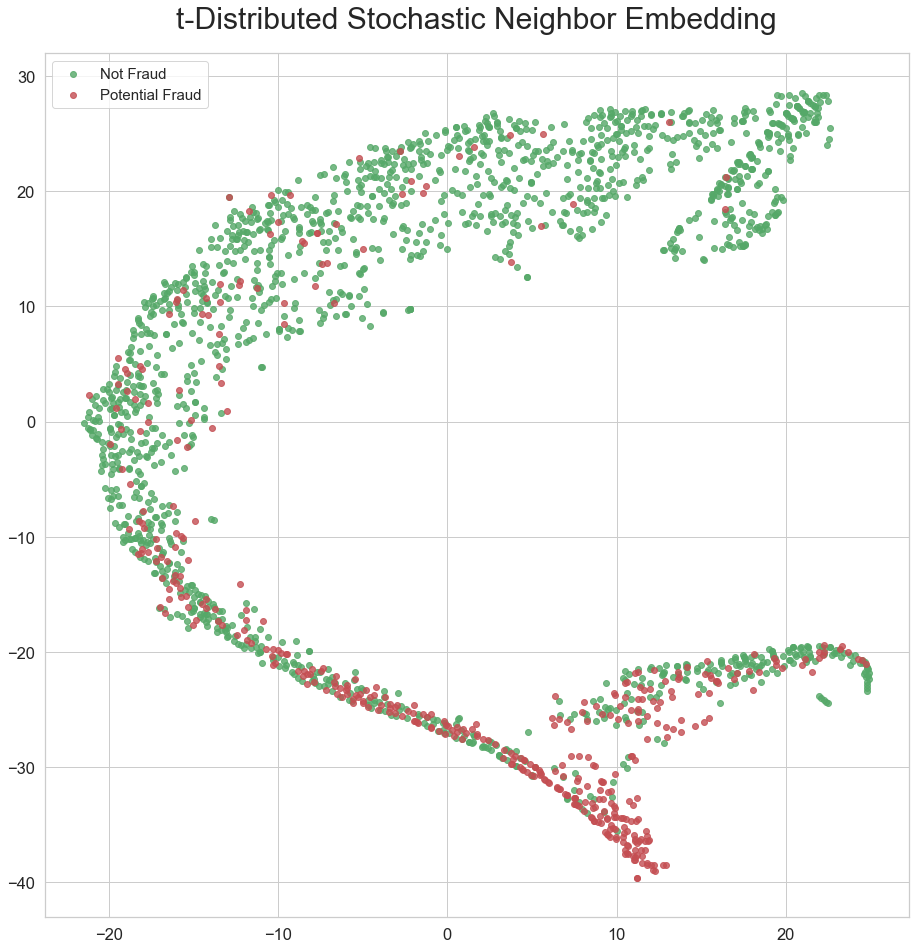

In [426]:
# scatterplot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(Xtsne[np.where(y_b.values == 0), 0], Xtsne[np.where(y_b.values == 0), 1],
           marker='o', color='g', linewidth=1, alpha=0.8, label='Not Fraud')
ax.scatter(Xtsne[np.where(y_b.values == 1), 0], Xtsne[np.where(y_b.values == 1), 1],
           marker='o', color='r', linewidth=1, alpha=0.8, label='Potential Fraud')
ax.legend(loc='best')
plt.title('t-Distributed Stochastic Neighbor Embedding')